## Import Libraries, Language Model, Settings

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random
import time
import datetime

import pandas_datareader as web # For collecting financial data
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm # For displaying progress during training

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # VADER sentiment model


In [2]:
from spacy.lang.en import English
import en_core_web_md
nlp = en_core_web_md.load()
en = English()


In [3]:
import warnings
warnings.filterwarnings('ignore')


## Scrap Data from Reddit

Please reference 'scrap_reddit.ipynb' for code that was used to scrap data from the Daily Discussion Threads on the WallStreetBets subreddit for this project.

## Upload Data from Reddit

In [4]:
data = pd.read_pickle('list_comments.pkl')
data


,comment,score,date,url_link,url_date
0,"Remember guys, if it’s good enough to post, do...",72,1.561984e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215
1,If you're a bull and you're asking if you shou...,51,1.561981e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215
2,I've seen a lot of retarded groups of people i...,35,1.561981e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215
3,Bought calls at the top because I hate money,37,1.561990e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215
4,"Yes sex is cool and all, but have you ever sol...",27,1.561989e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215
...,...,...,...,...,...
104925,I actually can't imagine what is going through...,7,1.593530e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593511907
104926,Hello 3 0 7 my old friend\n\nI've come to talk...,8,1.593530e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593511907
104927,This guy is killing bear fauci. Bullish,7,1.593530e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593511907
104928,Sell FSLY on green days and buy on red days. E...,7,1.593531e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593511907


## Clean Data and Get Sentiment

1. Add timestamps for the closing hour (4PM EST) for the date each comment was created
2. Remove comments that were created after the closing hour
3. Filter for comments using a score threshold
4. Get sentiment for each comment based on S&P500 performance that day

### 1. Add timestamps for the closing hour (4PM EST) for the date each comment was created

In [5]:
# Get timestamps for market close (4PM EST) for each date
def get_close_dates(dates):
    list_close_dates = []
    for i in dates:
        orig_date = datetime.datetime.fromtimestamp(i).strftime('%Y-%m-%d')
        # Get consistent 12:00 UTC for date each post was created
        temp_date = datetime.datetime.strptime(orig_date, '%Y-%m-%d')
        # Add 8 hours -> 20:00 UTC = 4PM EST (Market closing hour)
        close_date = time.mktime(temp_date.timetuple()) + 72000
        list_close_dates.append(close_date)
    return list_close_dates
    

In [6]:
close_dates = get_close_dates(list(data['url_date']))
data['close_date'] = close_dates
data


,comment,score,date,url_link,url_date,close_date
0,"Remember guys, if it’s good enough to post, do...",72,1.561984e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215,1.562026e+09
1,If you're a bull and you're asking if you shou...,51,1.561981e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215,1.562026e+09
2,I've seen a lot of retarded groups of people i...,35,1.561981e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215,1.562026e+09
3,Bought calls at the top because I hate money,37,1.561990e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215,1.562026e+09
4,"Yes sex is cool and all, but have you ever sol...",27,1.561989e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215,1.562026e+09
...,...,...,...,...,...,...
104925,I actually can't imagine what is going through...,7,1.593530e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593511907,1.593562e+09
104926,Hello 3 0 7 my old friend\n\nI've come to talk...,8,1.593530e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593511907,1.593562e+09
104927,This guy is killing bear fauci. Bullish,7,1.593530e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593511907,1.593562e+09
104928,Sell FSLY on green days and buy on red days. E...,7,1.593531e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593511907,1.593562e+09


### 2. Remove comments that were created after the closing hour

In [7]:
data_tradinghours = data[data.date < data.close_date]
data_tradinghours.index = range(len(data_tradinghours))
data_tradinghours


,comment,score,date,url_link,url_date,close_date
0,"Remember guys, if it’s good enough to post, do...",72,1.561984e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215,1.562026e+09
1,If you're a bull and you're asking if you shou...,51,1.561981e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215,1.562026e+09
2,I've seen a lot of retarded groups of people i...,35,1.561981e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215,1.562026e+09
3,Bought calls at the top because I hate money,37,1.561990e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215,1.562026e+09
4,"Yes sex is cool and all, but have you ever sol...",27,1.561989e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215,1.562026e+09
...,...,...,...,...,...,...
104888,I actually can't imagine what is going through...,7,1.593530e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593511907,1.593562e+09
104889,Hello 3 0 7 my old friend\n\nI've come to talk...,8,1.593530e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593511907,1.593562e+09
104890,This guy is killing bear fauci. Bullish,7,1.593530e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593511907,1.593562e+09
104891,Sell FSLY on green days and buy on red days. E...,7,1.593531e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593511907,1.593562e+09


### 3. Filter for comments using a score threshold

In [8]:
# Get list of counts for each score
score_counts = Counter(data_tradinghours['score'])
score_counts_sorted = dict(sorted(score_counts.items(),key = lambda i: i[0]))
score_counts_sorted


{-11: 2,
 -10: 1,
 -8: 1,
 -7: 1,
 -6: 1,
 -5: 1,
 -4: 2,
 -2: 2,
 -1: 1,
 0: 11,
 1: 85,
 2: 159,
 3: 3670,
 4: 8667,
 5: 12323,
 6: 12327,
 7: 10870,
 8: 9061,
 9: 7428,
 10: 6072,
 11: 5291,
 12: 4517,
 13: 3685,
 14: 2975,
 15: 2253,
 16: 1911,
 17: 1517,
 18: 1188,
 19: 1018,
 20: 792,
 21: 665,
 22: 612,
 23: 528,
 24: 467,
 25: 405,
 26: 384,
 27: 358,
 28: 310,
 29: 291,
 30: 280,
 31: 238,
 32: 218,
 33: 175,
 34: 186,
 35: 166,
 36: 133,
 37: 158,
 38: 138,
 39: 129,
 40: 117,
 41: 123,
 42: 123,
 43: 98,
 44: 98,
 45: 93,
 46: 77,
 47: 71,
 48: 63,
 49: 63,
 50: 67,
 51: 50,
 52: 78,
 53: 51,
 54: 58,
 55: 62,
 56: 49,
 57: 38,
 58: 29,
 59: 45,
 60: 48,
 61: 47,
 62: 38,
 63: 33,
 64: 33,
 65: 23,
 66: 44,
 67: 35,
 68: 39,
 69: 30,
 70: 27,
 71: 25,
 72: 26,
 73: 28,
 74: 26,
 75: 30,
 76: 19,
 77: 26,
 78: 26,
 79: 21,
 80: 24,
 81: 16,
 82: 23,
 83: 14,
 84: 20,
 85: 12,
 86: 25,
 87: 12,
 88: 18,
 89: 16,
 90: 10,
 91: 19,
 92: 17,
 93: 10,
 94: 15,
 95: 16,
 96: 8,
 97

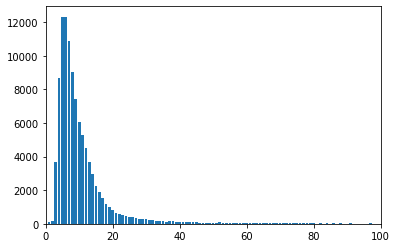

In [9]:
# Plot distribution of score counts
plt.bar(score_counts_sorted.keys(), score_counts_sorted.values())
plt.xlim([0, 100])
plt.show()


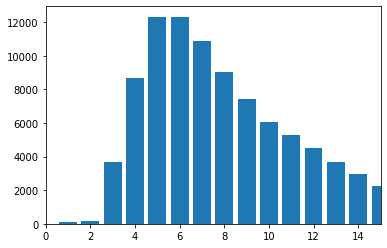

In [10]:
# Zoom in on scores between 0 and 15
plt.bar(score_counts_sorted.keys(), score_counts_sorted.values())
plt.xlim([0, 15])
plt.show()


Looks like most comments have scores of <5. I made the decision to keep comments with scores of >10 because they are likely more representative of the discussion post.

In [11]:
threshold = 6
data_scorefilter = data_tradinghours[data_tradinghours.score >= threshold]
data_scorefilter.index = range(len(data_scorefilter))
data_scorefilter


,comment,score,date,url_link,url_date,close_date
0,"Remember guys, if it’s good enough to post, do...",72,1.561984e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215,1.562026e+09
1,If you're a bull and you're asking if you shou...,51,1.561981e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215,1.562026e+09
2,I've seen a lot of retarded groups of people i...,35,1.561981e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215,1.562026e+09
3,Bought calls at the top because I hate money,37,1.561990e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215,1.562026e+09
4,"Yes sex is cool and all, but have you ever sol...",27,1.561989e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215,1.562026e+09
...,...,...,...,...,...,...
79961,I actually can't imagine what is going through...,7,1.593530e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593511907,1.593562e+09
79962,Hello 3 0 7 my old friend\n\nI've come to talk...,8,1.593530e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593511907,1.593562e+09
79963,This guy is killing bear fauci. Bullish,7,1.593530e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593511907,1.593562e+09
79964,Sell FSLY on green days and buy on red days. E...,7,1.593531e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593511907,1.593562e+09


### 4. Get sentiment for each comment based on S&P500 performance that day

#### 4A. Get S&P500 performance

In [12]:
url_dates = list(data['url_date'].unique()) # Get list of dates from the posts

start_date = datetime.datetime.fromtimestamp(url_dates[0]).strftime('%Y-%m-%d') 
end_date = datetime.datetime.fromtimestamp(url_dates[-1]).strftime('%Y-%m-%d')

data_sp500 = web.get_data_yahoo('^GSPC', start=start_date, end=end_date) #^GSPC = Ticker for S&P500
data_sp500['Change'] = (data_sp500['Close'] - data_sp500['Open']) / data_sp500['Open']
data_sp500


,High,Low,Open,Close,Volume,Adj Close,Change
Date,,,,,,,
2019-07-01,2977.929932,2952.219971,2971.409912,2964.330078,3513270000,2964.330078,-0.002383
2019-07-02,2973.209961,2955.919922,2964.659912,2973.010010,3206840000,2973.010010,0.002817
2019-07-03,2995.840088,2977.959961,2978.080078,2995.820068,1963720000,2995.820068,0.005957
2019-07-05,2994.030029,2967.969971,2984.250000,2990.409912,2434210000,2990.409912,0.002064
2019-07-08,2980.760010,2970.090088,2979.770020,2975.949951,2904550000,2975.949951,-0.001282
...,...,...,...,...,...,...,...
2020-06-24,3115.010010,3032.129883,3114.399902,3050.330078,5587200000,3050.330078,-0.020572
2020-06-25,3086.250000,3024.010010,3046.600098,3083.760010,4815420000,3083.760010,0.012197
2020-06-26,3073.729980,3004.629883,3073.199951,3009.050049,8098120000,3009.050049,-0.020874


#### 4B. Get sentiment for each comment

In [13]:
# Calculate sentiment based on daily percentage change
# compared to threshold:
# < negative threshold = 0 (negative)
# > positive threshold = 1 (positive)
# between negative and positive threshold = 2 (neutral)
def get_sentiment_sp500(list_dates, threshold):
    list_sentiments = []
    sentiment = 0
    for date in list_dates:
        try:
            index = np.datetime64(datetime.datetime.utcfromtimestamp(date).strftime('%Y-%m-%d'))
            change = data_sp500.loc[index]['Change']
            
            if change > threshold:
                sentiment = 1 # positive
            elif change < -threshold:
                sentiment = 0 # negative
            else:
                sentiment = 2 # neutral
                
            list_sentiments.append(sentiment)
        except:
            list_sentiments.append(sentiment)
    
    return list_sentiments


In [14]:
# Selected a threshold of 3% for large market movements that will generate positive/negative sentiment
data_sp500_sentiment = get_sentiment_sp500(data_scorefilter.url_date, 0.02)
data_sp500_sentiment


[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [15]:
Counter(data_sp500_sentiment)
# Most comments have neutral sentiment and there are similar numbers of positive and negative comments.


Counter({2: 67836, 0: 6676, 1: 5454})

In [16]:
data_scorefilter['sentiment'] = data_sp500_sentiment
data_scorefilter


,comment,score,date,url_link,url_date,close_date,sentiment
0,"Remember guys, if it’s good enough to post, do...",72,1.561984e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215,1.562026e+09,2
1,If you're a bull and you're asking if you shou...,51,1.561981e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215,1.562026e+09,2
2,I've seen a lot of retarded groups of people i...,35,1.561981e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215,1.562026e+09,2
3,Bought calls at the top because I hate money,37,1.561990e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215,1.562026e+09,2
4,"Yes sex is cool and all, but have you ever sol...",27,1.561989e+09,https://www.reddit.com/r/wallstreetbets/commen...,1561979215,1.562026e+09,2
...,...,...,...,...,...,...,...
79961,I actually can't imagine what is going through...,7,1.593530e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593511907,1.593562e+09,2
79962,Hello 3 0 7 my old friend\n\nI've come to talk...,8,1.593530e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593511907,1.593562e+09,2
79963,This guy is killing bear fauci. Bullish,7,1.593530e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593511907,1.593562e+09,2
79964,Sell FSLY on green days and buy on red days. E...,7,1.593531e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593511907,1.593562e+09,2


#### 4C. Filter for only comments with positive and negative sentiment

In [17]:
# Remove neutral comments because we want to train a model to detect positive and negative sentiment
data_sentimentfilter = data_scorefilter[data_scorefilter.sentiment != 2] # Sentiment 2 = neutral
data_sentimentfilter.index = range(len(data_sentimentfilter))
data_sentimentfilter


,comment,score,date,url_link,url_date,close_date,sentiment
0,I hear all these autists asking “dO I HoLd mY ...,70,1.566566e+09,https://www.reddit.com/r/wallstreetbets/commen...,1566558372,1.566605e+09,0
1,Love mornings like this around here...the shor...,62,1.566566e+09,https://www.reddit.com/r/wallstreetbets/commen...,1566558372,1.566605e+09,0
2,Trump's relationship with Powell reminds me of...,49,1.566572e+09,https://www.reddit.com/r/wallstreetbets/commen...,1566558372,1.566605e+09,0
3,I've never seen such a day in my life.\n\n* Ch...,49,1.566572e+09,https://www.reddit.com/r/wallstreetbets/commen...,1566558372,1.566605e+09,0
4,[deleted],95,1.566562e+09,https://www.reddit.com/r/wallstreetbets/commen...,1566558372,1.566605e+09,0
...,...,...,...,...,...,...,...
12125,Lol Pence cannot answer the mask question,9,1.593193e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593166484,1.593216e+09,0
12126,The only thing I like about pence is he says “...,9,1.593193e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593166484,1.593216e+09,0
12127,The 🐢 🚀,9,1.593193e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593166484,1.593216e+09,0
12128,BTFD\n\ndisclaimer: does not apply during a de...,9,1.593193e+09,https://www.reddit.com/r/wallstreetbets/commen...,1593166484,1.593216e+09,0


#### 4D. Create DataFrame with text (comment) / label (sentiment) for training and testing

In [18]:
df = pd.DataFrame({'text': data_sentimentfilter.comment, 'label': data_sentimentfilter.sentiment})
df


,text,label
0,I hear all these autists asking “dO I HoLd mY ...,0
1,Love mornings like this around here...the shor...,0
2,Trump's relationship with Powell reminds me of...,0
3,I've never seen such a day in my life.\n\n* Ch...,0
4,[deleted],0
...,...,...
12125,Lol Pence cannot answer the mask question,0
12126,The only thing I like about pence is he says “...,0
12127,The 🐢 🚀,0
12128,BTFD\n\ndisclaimer: does not apply during a de...,0


## Topic Model using Non-Negative Matrix Factorization (NMF)

### Between positive and negative sentiment

In [20]:
# Tokenizer
# Adapted from week_1_intro.ipynb
def tokenizer_full(doc):
    parsed = nlp(doc)
    tokens = []
    for t in parsed:
        if t.like_url: # Remove URLs
            continue
        if t.like_num: # Remove numbers
            continue
        if t.like_email: # Remove emails
            continue
        if t.is_currency: # Remove currency symbols because people spam '$' a lot
            continue
        if (t.is_stop or t.is_punct): # Remove stop-words and punctuation
            continue
        t = t.lemma_ # Lemmatization
        tokens.append(t)
    return(tokens)


In [107]:
# Split the dataset into a training, a validation and a test dataset
# Adapted from midterm_student_nhanhuynh.ipynb
pct_train = 0.7
pct_val = 0.3
train_bool = np.random.random(len(df))<=pct_train
train = df[train_bool]
test = df[~train_bool]
val_bool = np.random.random(size=len(train))<=pct_val
val = train[val_bool]
train = train[~val_bool]
print(len(train), len(val), len(test))


5189 2267 3245


In [108]:
def split(data):
    X = list(data['text'])
    Y = list(data['label'])
    return X,Y


In [109]:
X_train, Y_train = split(train)
X_val, Y_val = split(val)
X_test, Y_test = split(test)


In [49]:
# TF-IDF vectors (with document frequency thresholds for very uncommon and very common words)
tfidf = TfidfVectorizer(tokenizer=tokenizer_full, min_df=0.005, max_df=0.9)
tfidf_vectors = tfidf.fit_transform(X_train).toarray()
tfidf_df = pd.DataFrame(tfidf_vectors, columns=tfidf.get_feature_names())
tfidf_df


,\n,\n\n,\n\n\n,\n\n,,\n\n,+,-PRON-,100k,50k,...,yeah,year,yes,yesterday,yolo,’,’s,🌈,🐻,😂
0,0.0,0.154810,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.335525,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.246454,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,0.0,0.205228,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
516,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
517,0.0,0.328383,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
518,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0


In [50]:
# Non-Negative Matrix Factorization-Based Representations
nmf = NMF(n_components=10)
nmf_vectors = nmf.fit_transform(tfidf_vectors)


In [32]:
# Adapted from week_2_vectors.ipynb
def display_components(model, word_features, top_display=5):
    # utility for displaying respresentative words per component for topic models
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        top_words_idx = topic.argsort()[::-1][:top_display]
        top_words = [word_features[i] for i in top_words_idx]
        print(" ".join(top_words))
        

In [33]:
display_components(nmf, tfidf.get_feature_names())


Topic 0:
delete soon sure take robinhood
Topic 1:
market trump stock say look
Topic 2:


 bull > shit  
Topic 3:
put hold sell hand diamond
Topic 4:
fuck robinhood holy shit lol
Topic 5:
go to today shit open
Topic 6:
money be lose not today
Topic 7:
buy call dip guy yesterday
Topic 8:
spy lol close get  
Topic 9:
day like feel get bull


Several of these topics clearly represent positive or negative sentiment. Topics 4, 5, 6 have profanities and references to losing money while topics 7, 9 have references to buying stocks and bull markets.

In [34]:
# Adapted from assignment3_nhanhuynh.ipynb
def run_pipeline(pipeline):
    # Fit the model on the training data
    pipeline.fit(X_train, Y_train)
    # Calculate an accuracy score using the validation data
    Y_val_pred = pipeline.predict(X_val)
    return accuracy_score(Y_val, Y_val_pred)


In [112]:
# Fit SVM model to predict sentiment using NMF topic model
nmf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenizer_full, min_df=0.02, max_df=0.9)),
    ('nmf', NMF(n_components=10)),
    ('svc', LinearSVC())
])

run_pipeline(nmf_pipeline)


0.5527128363475959

In [113]:
# Fit SVM model to predict sentiment using TF-IDF vectors
tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenizer_full, min_df=0.02, max_df=0.9)),
    ('svc', LinearSVC())
])

run_pipeline(tfidf_pipeline)


0.5593295103661227

## Fine-tuned BERT Model

Please reference 'run_bert.ipynb' for code that was used to fine-tune and train BERT on this dataset.

## VADER Social Media Sentiment Model

In [19]:
vader_model = SentimentIntensityAnalyzer()

vader_sentiment = []
for text in df.text:
    sentiment_score = vader_model.polarity_scores(text)['compound']
    vader_sentiment.append(int(np.where(sentiment_score > 0, 1, 0))) # 1: positive, 0: negative
    
vader_sentiment


[0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,


In [20]:
vader_compare = pd.DataFrame({'sentiment': df.label, 'prediction': vader_sentiment})
vader_compare['match'] = np.where(vader_compare['sentiment'] == vader_compare['prediction'], 1, 0)
vader_accuracy = np.sum(vader_compare['match']) / len(vader_compare['match'])
vader_accuracy


0.5204451772464963